In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import gpflow

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# custom dirichlet likelihood
import custom_likelihoods 
import VFF


sns.set_context('notebook')
sns.set_style('white')

# reproducibility:
np.random.seed(0)
tf.random.set_seed(123)

f64 = gpflow.utilities.to_default_float
gpflow.config.set_default_float(np.float64)

<h3> Create the Data</h3>
Sample from some GP, then transform sampled function with exp to our used concentrations.
Given the concentrations, sample the ratios y that are our data.
The x are just randomly distributed within [0,1].

Data generation process mainly motivated by the
<a href="https://gpflow.readthedocs.io/en/master/notebooks/advanced/multiclass_classification.html">GPFlow Multiclass Classification Notebook</a>.

In [3]:
# Number of different classes / dimension of concentration parameter
C = 3
# Number of samples used drawn for training data
N = 200

# x position of training data
X = np.random.rand(N, 1)
# x positions used for plotting / predicting later on
xx = np.linspace(0, 1, 100).reshape(-1,1)

# lengthscales used for the GP
lengthscales = [0.3]*C

# SquaredExponential kernel matrix
kernel_se = gpflow.kernels.SquaredExponential(lengthscales=lengthscales, variance=0.2)
jitter_eye = np.eye(N) * 1e-6
K = kernel_se(X) + jitter_eye

# Latents prior sample
f = np.random.multivariate_normal(mean=np.zeros(N), cov=K, size=(C)).T
a = np.exp(f)  
a_sum = np.sum(a, axis=1).reshape(-1,1)
a_expectation = a / a_sum

dir = tfd.Dirichlet(a)

Y = tf.reduce_mean(dir.sample(1), 0).numpy()
Y_exp = a_expectation#np.argmax(f, 1).reshape(-1,).astype(int)

c_sum = tf.reduce_sum(a, axis = -1)[..., tf.newaxis]
Y_var= a * (c_sum - a) / (c_sum**2 * (c_sum+1))

dataset = tf.data.Dataset.from_tensor_slices((X, a_expectation)).shuffle(N).batch(50)

<h3>Plotting Utilities</h3>

In [4]:
def plot_ratios(xx, samples_mean, samples_std, ips, scatter= False, title=""):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,6), sharex=True)
    colors = ["blue", "red", "green", "yellow"]
    for c in range(C):
        if scatter:
            ax1.scatter(xx, samples_mean[:, c], marker='+', color=colors[c], label=str(c))
        else:
            ax1.plot(xx, samples_mean[:, c], color=colors[c], label=str(c))
            ax1.fill_between(xx.reshape(-1), samples_mean[:, c]-samples_std[:,c], samples_mean[:, c]+samples_std[:,c], 
                             alpha=0.3)
    ax1.set_ylabel("ratio")
    ax1.set_ylim((0,1))
    ax1.grid()
    plt.legend(f"{c}" for c in range(C))
    
    ratios = [samples_mean[:, c] for c in range(C)]
    ax2.stackplot(xx.reshape(-1), ratios, alpha=0.2, colors=colors)
    ax2.set_ylabel("ratio")
    ax2.set_ylim((0,1))
    ax2.grid()
    ax2.legend([f"{c}" for c in range(C)])
    
    
    if ips is not None:
        ax2.scatter(ips, np.repeat(0, ips.shape[0]), marker='|', c='black')
        ax1.scatter(ips, np.repeat(0, ips.shape[0]), marker='|', c='black')
    plt.xlabel('$X$')
    plt.xlim((0,1))
    plt.suptitle(title)
    plt.show()
    

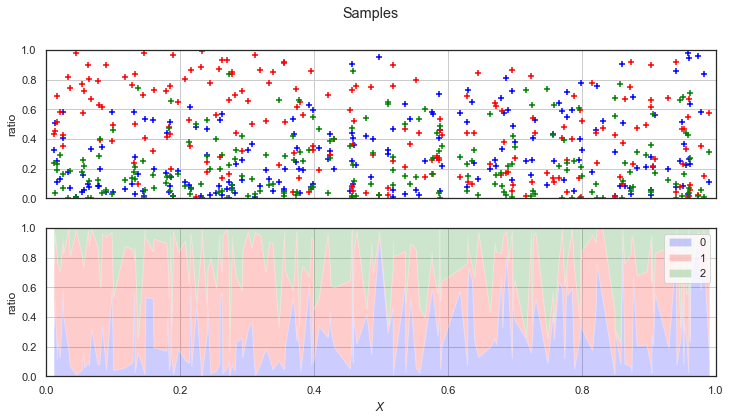

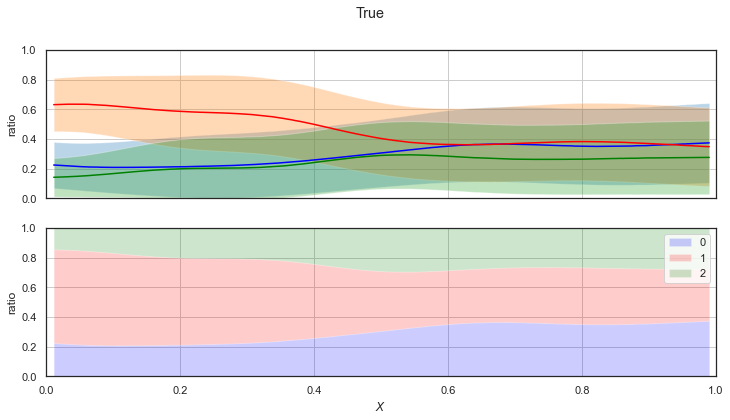

In [5]:
order = np.argsort(X.reshape(-1,))
plot_ratios(X[order,...], Y[order, ...], None, scatter=True, title="Samples", ips = None)
plot_ratios(X[order,...], Y_exp[order, ...], np.sqrt(Y_var.numpy())[order, ...], scatter=False, title="True", ips=None)

<h3> Create SPGMC Model with our custom likelihood </h3>

In [ ]:
kernel = gpflow.kernels.Matern32(lengthscales = [0.1]) + gpflow.kernels.White(variance=0.01)
likelihood = Dirichlet()
Z = np.linspace(0, 1, 20).reshape(-1,1)

m = gpflow.models.SGPMC((X,Y), kernel=kernel, likelihood=likelihood, inducing_variable=Z, num_latent_gps=C)
gpflow.utilities.set_trainable(m.kernel.kernels[1].variance, False)
gpflow.utilities.set_trainable(m.inducing_variable, True)

m.kernel.kernels[0].variance.prior = tfp.distributions.Gamma(f64(1.), f64(1.))
m.kernel.kernels[0].lengthscales.prior = tfp.distributions.Gamma(f64(2.), f64(2.))

gpflow.utilities.print_summary(m)

In [28]:
<h3> Train our SPGMC Model using Stochastic Variational Inference</h3>
This is required for optimizing the inducing points and finding initial starting values for the hyperparameters. 
We use ADAM as an optimizer..

NameError: name 'Dirichlet' is not defined

<h3> Train our SPGMC Model using Stochastic Variational Inference</h3>
This is required for optimizing the inducing points and finding initial starting values for the hyperparameters. 
We use ADAM as an optimizer..

In [25]:
opt = gpflow.optimizers.Scipy()
opt.minimize(m.training_loss, m.trainable_variables)

gpflow.utilities.print_summary(m, fmt='notebook')

name,class,transform,prior,trainable,shape,dtype,value
SGPMC.kernel.kernels[0].variance,Parameter,Softplus,Gamma,True,(),float64,1.6579837222881273
SGPMC.kernel.kernels[0].lengthscales,Parameter,Softplus,Gamma,True,"(1,)",float64,[0.13894591]
SGPMC.kernel.kernels[1].variance,Parameter,Softplus,,False,(),float64,0.009999999999999893
SGPMC.inducing_variable.Z,Parameter,,,True,"(20, 1)",float64,[[0.01196049...
SGPMC.V,Parameter,,Normal,True,"(20, 3)",float64,"[[0.38356709, 0.89684529, -0.00452679..."


<h3> Prediction using just SVGP optimization </h3>

In [26]:
m.likelihood.num_monte_carlo_points = 2000
y_mu_SVGP, y_var_SVGP = m.predict_y(xx)

<h3> MCMC sampling of variational approximation</h3>

In [21]:
burn = 50
num_samples = 100

hmc_helper =  gpflow.optimizers.SamplingHelper(
    m.log_posterior_density, m.trainable_parameters
)

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=hmc_helper.target_log_prob_fn,
    num_leapfrog_steps=10,
    step_size=0.01
)

adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    hmc,
    num_adaptation_steps=10,
    target_accept_prob=.75,
    adaptation_rate=0.1
)

@tf.function
def run_chain_fn():
    return tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=burn,
        current_state=hmc_helper.current_state,
        kernel=adaptive_hmc,
        trace_fn = lambda _, pkr: pkr.inner_results.is_accepted
    )

samples, _ = run_chain_fn()


ValueError: `parameters` should only contain gpflow.Parameter objects with priors

In [18]:
y_samples_mu = []
y_samples_std = []
for i in range(0, num_samples, 1):
    for var, var_samples in zip(hmc_helper.current_state, samples):
        var.assign(var_samples[i])
    f_mcmc = m.predict_f_samples(xx, 10)
    y_samples_mcmc = tf.reduce_mean(m.likelihood._sample_dir(m.likelihood.invlink(f_mcmc), 10), 0)
    samples_mean = tf.reduce_mean(y_samples_mcmc, 0)
    samples_std = tf.math.reduce_std(y_samples_mcmc, 0)
    y_samples_mu.append(samples_mean)
    y_samples_std.append(samples_std)

NameError: name 'hmc_helper' is not defined

In [19]:
y_samples_mu_joined = np.mean(np.stack(y_samples_mu), 0)
y_samples_std_joined = np.std(np.stack(y_samples_mu), 0)


ValueError: need at least one array to stack

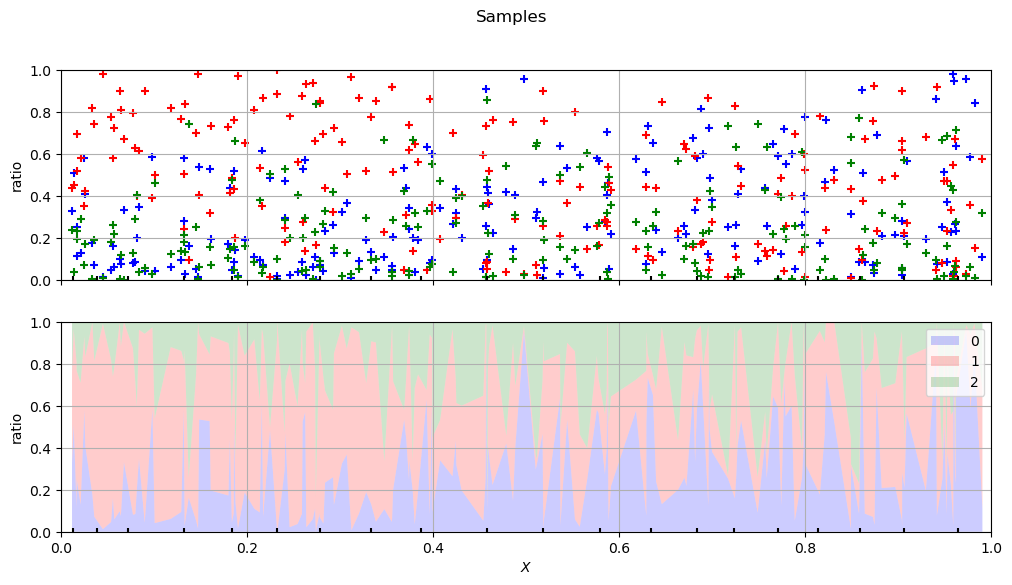

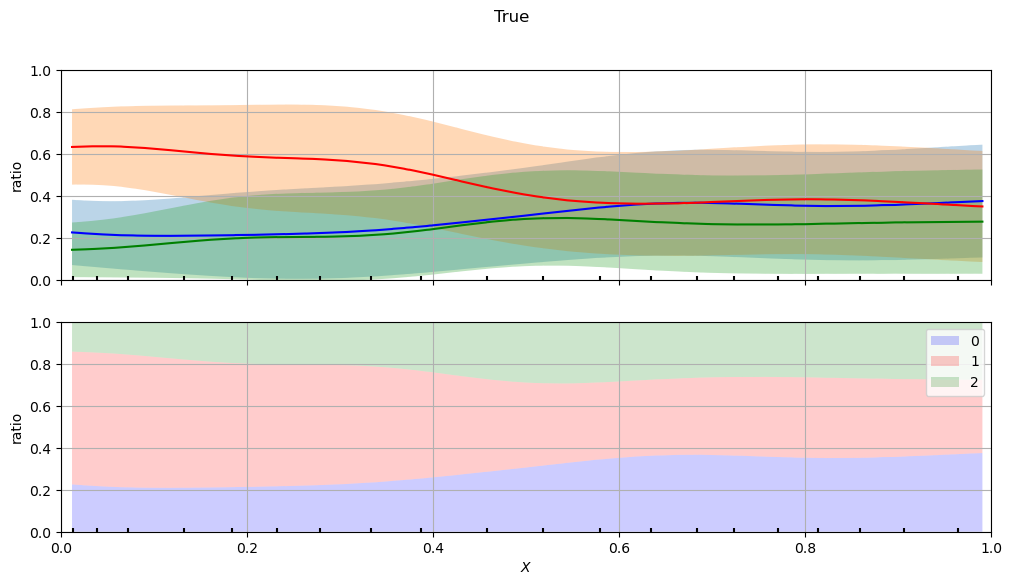

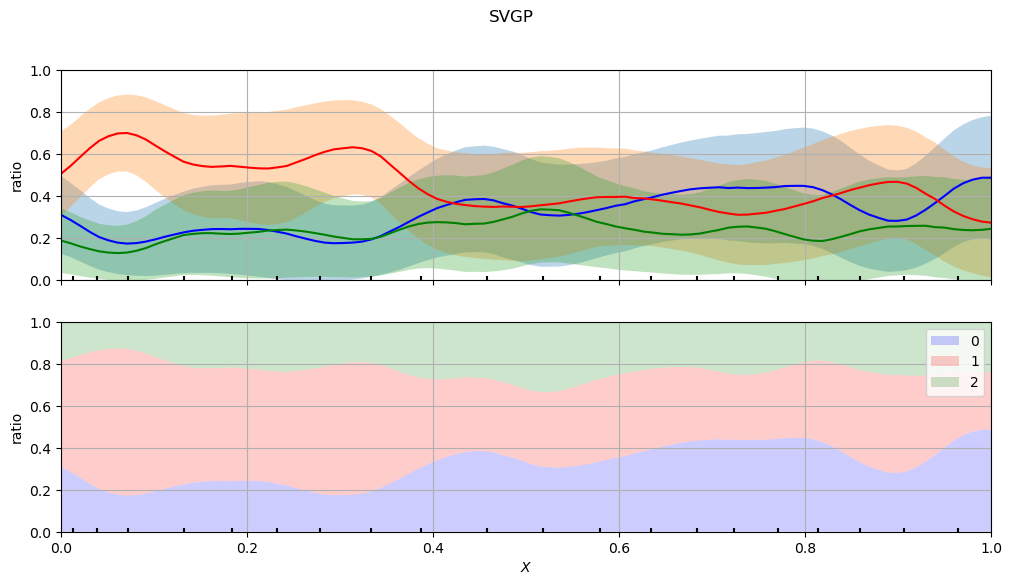

NameError: name 'y_samples_mu_joined' is not defined

In [20]:
sns.reset_defaults()
order = np.argsort(X.reshape(-1,))
ips = m.inducing_variable.Z.numpy().reshape(-1)
plot_ratios(X[order,...], Y[order, ...], None, scatter=True, title="Samples", ips=ips)
plot_ratios(X[order,...], Y_exp[order, ...], np.sqrt(Y_var.numpy())[order, ...], scatter=False, title="True", ips=ips)
plot_ratios(xx, y_mu_SVGP, np.sqrt(y_var_SVGP), title="SVGP", scatter=False, ips=ips)
plot_ratios(xx, y_samples_mu_joined, y_samples_std_joined, title="SGPMC", scatter=False, ips=ips)

